In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import time
from PIL import Image
import numpy as np
from RandAugment import RandAugment
from pathlib import Path

In [2]:
source_dir = '/scratch/ssd004/scratch/junejory/'
train_dir = '/scratch/ssd004/scratch/junejory/train2019'
val_dir = '/scratch/ssd004/scratch/junejory/val2019'
train_json = '/scratch/ssd004/scratch/junejory/train2019.json'
val_json = '/scratch/ssd004/scratch/junejory/val2019.json'
categories_json = '/scratch/ssd004/scratch/junejory/categories.json'
rsource_dir = '/datasets/inat_comp/2019/train_val2019'

In [3]:
train_dir = '/datasets/inat_comp/2021/train_mini'
val_dir = '/datasets/inat_comp/2021/val'
train_json = '/datasets/inat_comp/2021/train_mini.json'
val_json = '/datasets/inat_comp/2021/val.json'

In [4]:
def load_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [5]:
train_data = load_json(train_json)
val_data = load_json(val_json)

In [6]:
train_data

{'info': {'year': 2021,
  'verion': 1,
  'description': 'iNaturalist Species Classification Dataset Mini Training Split.',
  'contributor': 'Grant Van Horn and the Visipedia Team.',
  'url': 'https://github.com/visipedia/inat_comp',
  'date_created': '2021-03-01 12:34:38'},
 'images': [{'id': 0,
   'width': 500,
   'height': 500,
   'file_name': 'train_mini/02912_Animalia_Chordata_Actinopterygii_Siluriformes_Ictaluridae_Ameiurus_nebulosus/d615f184-8af4-4c60-b9f8-3081c1607644.jpg',
   'license': 0,
   'rights_holder': 'Ken-ichi Ueda',
   'date': '2010-07-14 20:19:00+00:00',
   'latitude': 43.83486,
   'longitude': -71.22231,
   'location_uncertainty': 77},
  {'id': 7,
   'width': 500,
   'height': 333,
   'file_name': 'train_mini/05804_Plantae_Tracheophyta_Liliopsida_Alismatales_Araceae_Peltandra_virginica/20c02c2d-a2c7-4f44-895c-ae3d5bb7c82c.jpg',
   'license': 0,
   'rights_holder': 'Ken-ichi Ueda',
   'date': '2011-06-10 22:08:00+00:00',
   'latitude': 41.41572,
   'longitude': -72.5

In [7]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [8]:
walk_through_dir(train_dir)

There are 10000 directories and 0 images in '/datasets/inat_comp/2021/train_mini'.
There are 0 directories and 50 images in '/datasets/inat_comp/2021/train_mini/08351_Plantae_Tracheophyta_Magnoliopsida_Gentianales_Rubiaceae_Houstonia_purpurea'.
There are 0 directories and 50 images in '/datasets/inat_comp/2021/train_mini/06760_Plantae_Tracheophyta_Magnoliopsida_Asterales_Asteraceae_Encelia_californica'.
There are 0 directories and 50 images in '/datasets/inat_comp/2021/train_mini/00989_Animalia_Arthropoda_Insecta_Lepidoptera_Erebidae_Caenurgina_crassiuscula'.
There are 0 directories and 50 images in '/datasets/inat_comp/2021/train_mini/03228_Animalia_Chordata_Aves_Anseriformes_Anatidae_Branta_leucopsis'.
There are 0 directories and 50 images in '/datasets/inat_comp/2021/train_mini/09059_Plantae_Tracheophyta_Magnoliopsida_Myrtales_Onagraceae_Oenothera_curtiflora'.
There are 0 directories and 50 images in '/datasets/inat_comp/2021/train_mini/00698_Animalia_Arthropoda_Insecta_Hymenoptera_

In [9]:
tp = Path(train_dir)
image_path = tp
if image_path.is_dir():
    print(f"{image_path} directory exists.")

/datasets/inat_comp/2021/train_mini directory exists.


Random image path: /datasets/inat_comp/2021/train_mini/07899_Plantae_Tracheophyta_Magnoliopsida_Fabales_Fabaceae_Acmispon_argophyllus/4b8027c0-0769-47ae-9543-820aae1e449b.jpg
Image class: 07899_Plantae_Tracheophyta_Magnoliopsida_Fabales_Fabaceae_Acmispon_argophyllus
Image height: 500
Image width: 375


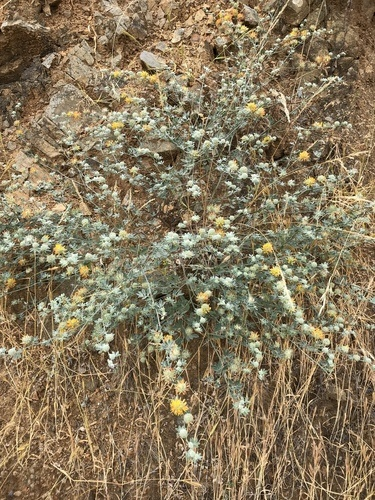

In [10]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

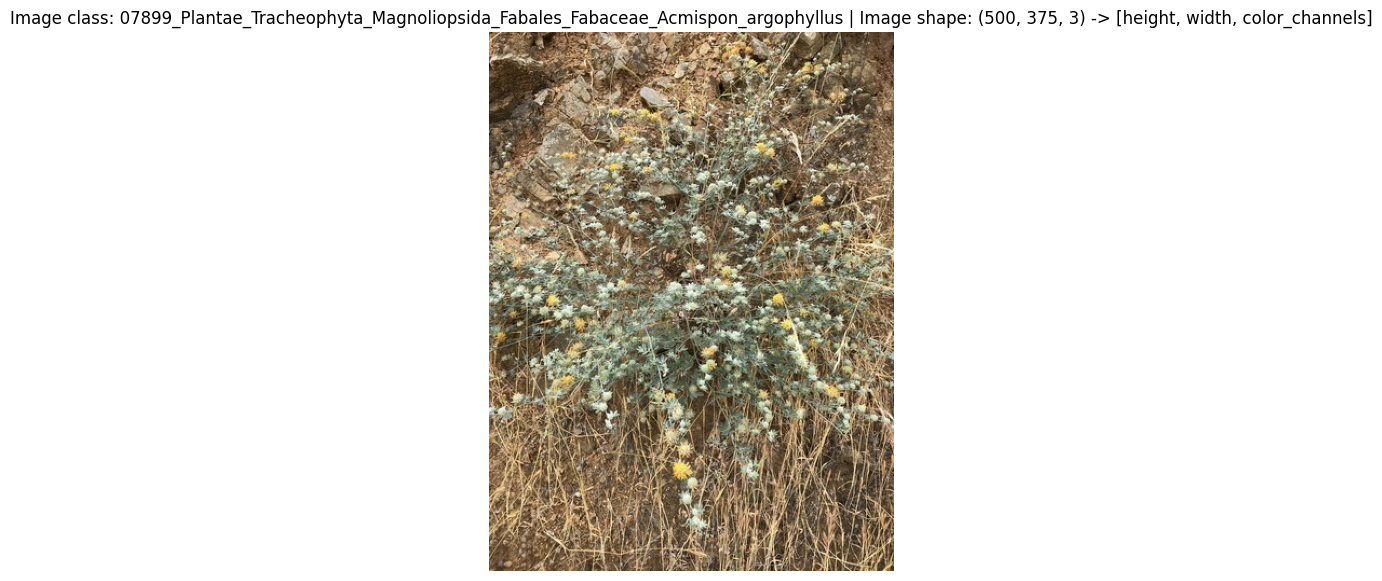

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [12]:
int(0.5)

0

In [13]:
# Write transform for image
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=9, magnitude=1), #9 Augmentations with Magnitude 0.5
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


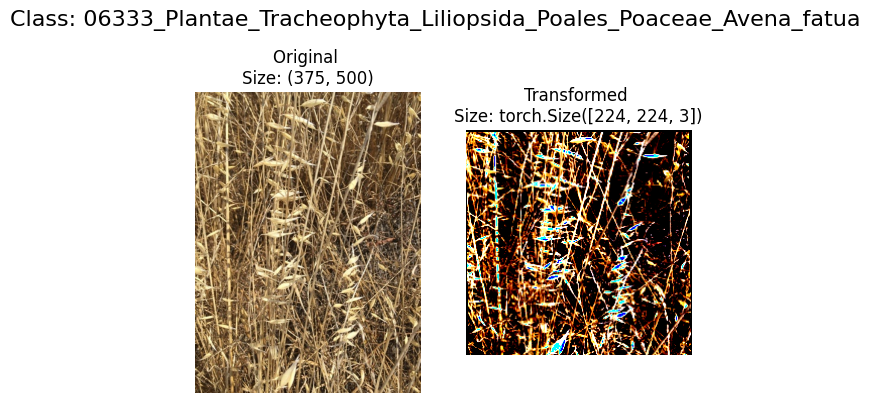

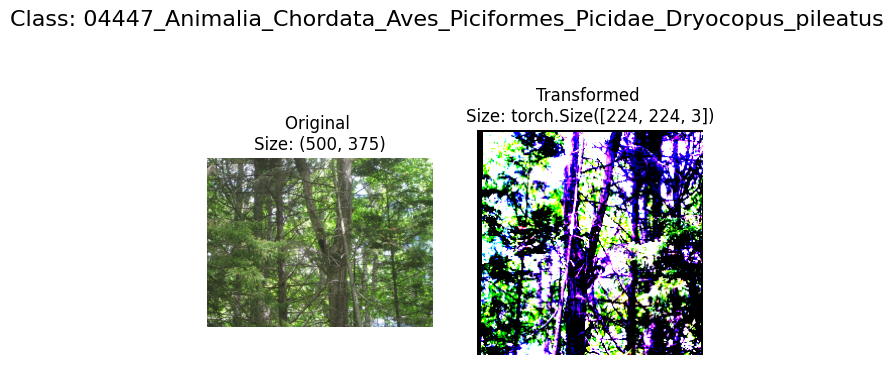

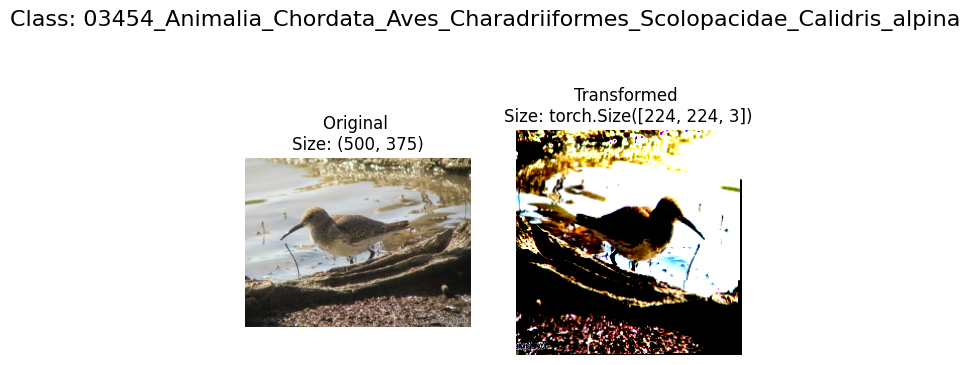

In [14]:
import matplotlib.pyplot as plt
def plot_transformed_images(image_paths, transform, n=3, seed=100):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2391288].


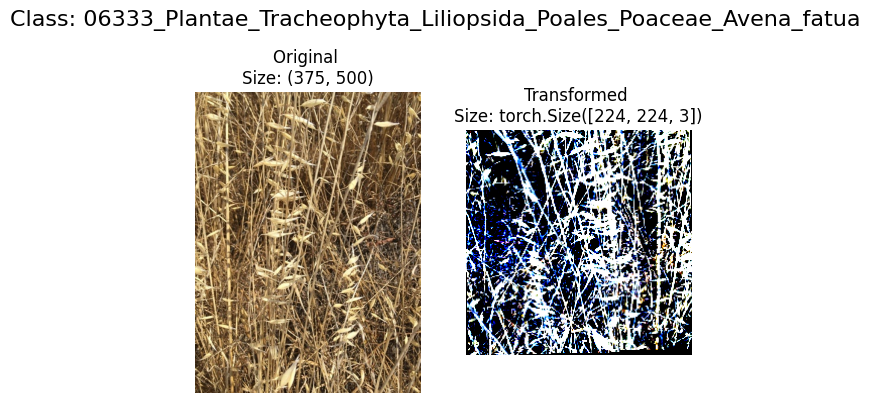

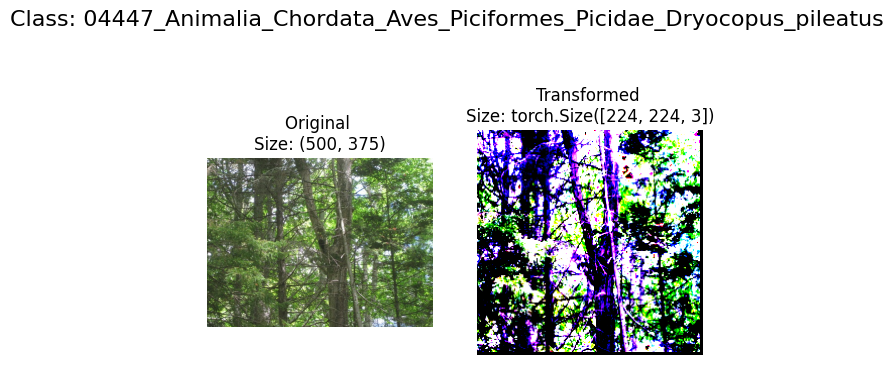

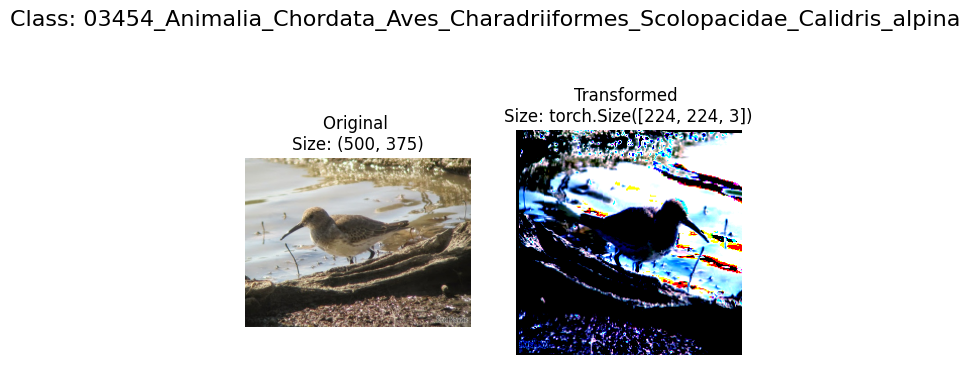

In [15]:
import matplotlib.pyplot as plt
def plot_transformed_images(image_paths, transform, n=3, seed=100):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

In [16]:
def get_image_data(annotations):
    images = {img['id']: img['file_name'] for img in annotations['images']}
    img_to_annotations = {ann['image_id']: ann['category_id'] for ann in annotations['annotations']}
    return images, img_to_annotations

train_images, train_img_to_annotations = get_image_data(train_data)
val_images, val_img_to_annotations = get_image_data(val_data)

In [17]:
val_images

{2686843: 'val/03938_Animalia_Chordata_Aves_Passeriformes_Meliphagidae_Ptilotula_penicillata/df8edd4c-fbb4-4886-8600-a429e5efac23.jpg',
 2686844: 'val/03583_Animalia_Chordata_Aves_Cuculiformes_Cuculidae_Coccyzus_erythropthalmus/fc35080c-5ace-4485-a21f-b1447f27efc7.jpg',
 2686845: 'val/05585_Fungi_Basidiomycota_Agaricomycetes_Agaricales_Strophariaceae_Pholiota_squarrosa/4a1df4d1-4cd8-469d-8496-7b025a5b73cd.jpg',
 2686846: 'val/04487_Animalia_Chordata_Aves_Procellariiformes_Diomedeidae_Phoebastria_nigripes/5a89f160-b085-4990-a66a-aac18059b7da.jpg',
 2686847: 'val/05282_Animalia_Mollusca_Gastropoda_Neogastropoda_Buccinidae_Sinistrofulgur_sinistrum/3b188349-0528-4aff-bc15-6218e16f8e10.jpg',
 2686848: 'val/03253_Animalia_Chordata_Aves_Anseriformes_Anatidae_Mareca_americana/d5359888-d956-46a0-9dfb-87099ee1e6dc.jpg',
 2686849: 'val/05813_Plantae_Tracheophyta_Liliopsida_Alismatales_Hydrocharitaceae_Stratiotes_aloides/6ba17b04-5e1d-40d2-b60a-183676f2ad9b.jpg',
 2686850: 'val/05626_Fungi_Basidio

In [18]:
from torchvision import datasets
train_dataset = datasets.ImageFolder(train_dir, transform = data_transform, target_transform= None)
val_dataset = datasets.ImageFolder(val_dir, transform = data_transform, target_transform= None)


In [19]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 500000
    Root location: /datasets/inat_comp/2021/train_mini
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               RandAugment(num_ops=9, magnitude=1, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [20]:
img, label = train_dataset[3454][0], train_dataset[3454][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-2.1179, -2.1179, -0.7822,  ...,  0.5022,  0.2624,  0.6392],
         [-2.1179, -2.1179,  0.1083,  ...,  0.5707,  0.8618,  1.0331],
         [-2.1179, -2.1179, -0.0116,  ...,  0.6392,  1.2043,  1.2043],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -0.6702,  ...,  0.6078,  0.3102,  0.6954],
         [-2.0357, -2.0357,  0.3277,  ...,  0.6078,  0.9230,  1.0805],
         [-2.0357, -2.0357,  0.3277,  ...,  0.6954,  1.2556,  1.2556],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -0.5844,  ...,  0.9145,  0.4962,  0.8971],
         [-1.8044, -1.8044,  0.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].


Original shape: torch.Size([3, 224, 224]) -> [color_channels, height, width]
Image permute shape: torch.Size([224, 224, 3]) -> [height, width, color_channels]


NameError: name 'class_names' is not defined

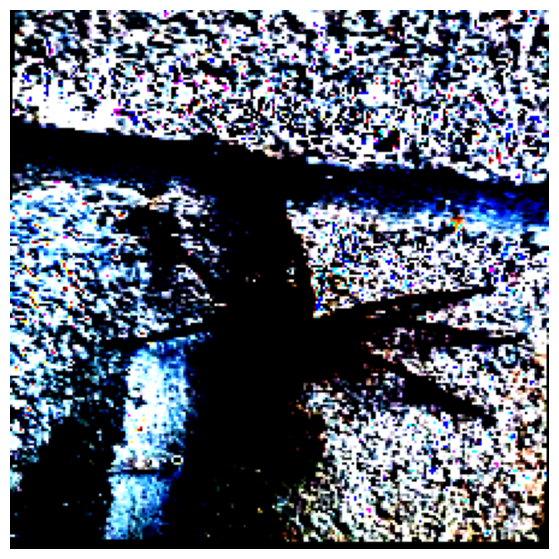

In [21]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [22]:
os.cpu_count()

32

In [23]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_dataset, 
                              batch_size=512, # how many samples per batch?
                              num_workers=16, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

val_dataloader = DataLoader(dataset=val_dataset, 
                             batch_size=512, 
                             num_workers=16, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, val_dataloader

/fs01/home/junejory/miniforge3/envs/hiera/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(<torch.utils.data.dataloader.DataLoader at 0x7f1f8a752590>,
 <torch.utils.data.dataloader.DataLoader at 0x7f20a82cf4f0>)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
from torch import Tensor
# Define the DropPath function
def drop_path(x: Tensor, keep_prob: float = 1.0, inplace: bool = False) -> Tensor:
    mask_shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    mask = x.new_empty(mask_shape).bernoulli_(keep_prob)
    mask.div_(keep_prob)
    if inplace:
        x.mul_(mask)
    else:
        x = x * mask
    return x

# Define the DropPath module
class DropPath(nn.Module):
    def __init__(self, p: float = 0.5, inplace: bool = False):
        super().__init__()
        self.p = p
        self.inplace = inplace

    def forward(self, x: Tensor) -> Tensor:
        if self.training and self.p > 0:
            x = drop_path(x, self.p, self.inplace)
        return x

    def __repr__(self):
        return f"{self.__class__.__name__}(p={self.p})"

# Modify the Bottleneck block to include DropPath
class ConvBnAct(nn.Sequential):
    def __init__(self, in_features: int, out_features: int, kernel_size=1):
        super().__init__(
            nn.Conv2d(in_features, out_features, kernel_size=kernel_size, padding=kernel_size // 2),
            nn.BatchNorm2d(out_features),
            nn.ReLU()
        )

class BottleNeck(nn.Module):
    def __init__(self, in_features: int, out_features: int, reduction: int = 4, drop_prob: float = 0.1):
        super().__init__()
        self.block = nn.Sequential(
            ConvBnAct(in_features, out_features // reduction, kernel_size=1),
            ConvBnAct(out_features // reduction, out_features // reduction, kernel_size=3),
            ConvBnAct(out_features // reduction, out_features, kernel_size=1),
        )
        self.drop_path = DropPath(p=drop_prob)
        
    def forward(self, x: Tensor) -> Tensor:
        res = x
        x = self.block(x)
        x = self.drop_path(x)
        return x + res

In [26]:
len(train_dataset.classes)

10000

In [27]:

num_classes = len(train_dataset.classes)
print(num_classes)
model = torch.hub.load("facebookresearch/hiera", model="hiera_tiny_224", pretrained=True, checkpoint="mae_in1k")
for name, module in model.named_children():
    if isinstance(module, BottleNeck):
        setattr(model, name, BottleNeck(module.in_features, module.out_features, drop_prob=0.1))
model.head.projection = nn.Linear(in_features=model.head.projection.in_features, out_features=num_classes)
model = model.to(device)

10000


Using cache found in /h/junejory/.cache/torch/hub/facebookresearch_hiera_main


In [28]:
layer_names = []
for idx, (name, param) in enumerate(model.named_parameters()):
    layer_names.append(name)
    #print(f'{idx}: {name}')
layer_names.reverse()
#layer_names[0:5]


In [29]:
# learning rate
lr      = 3e-3    #adjusted so first layer is 2e-3
lr_mult = 0.65

# placeholder
parameters      = []
prev_group_name = layer_names[0].split('.')[0]

# store params & learning rates
for idx, name in enumerate(layer_names):
    
    # parameter group name
    if name == "pos_embed":
        pass
    else:
        cur_group_name = name.split('.')[1]
        # update learning rate
        if cur_group_name == "weight":
            pass
        elif cur_group_name != prev_group_name:
            lr *= lr_mult
        prev_group_name = cur_group_name
    
    # display info
    print(f'{idx}: lr = {lr:.6f}, {name}')
    
    # append layer parameters
    parameters += [{'params': [p for n, p in model.named_parameters() if n == name and p.requires_grad],
                    'lr':     lr}]

0: lr = 0.001950, head.projection.bias
1: lr = 0.001950, head.projection.weight
2: lr = 0.001268, norm.bias
3: lr = 0.001268, norm.weight
4: lr = 0.000824, blocks.11.mlp.fc2.bias
5: lr = 0.000824, blocks.11.mlp.fc2.weight
6: lr = 0.000824, blocks.11.mlp.fc1.bias
7: lr = 0.000824, blocks.11.mlp.fc1.weight
8: lr = 0.000824, blocks.11.norm2.bias
9: lr = 0.000824, blocks.11.norm2.weight
10: lr = 0.000824, blocks.11.attn.proj.bias
11: lr = 0.000824, blocks.11.attn.proj.weight
12: lr = 0.000824, blocks.11.attn.qkv.bias
13: lr = 0.000824, blocks.11.attn.qkv.weight
14: lr = 0.000824, blocks.11.norm1.bias
15: lr = 0.000824, blocks.11.norm1.weight
16: lr = 0.000536, blocks.10.proj.bias
17: lr = 0.000536, blocks.10.proj.weight
18: lr = 0.000536, blocks.10.mlp.fc2.bias
19: lr = 0.000536, blocks.10.mlp.fc2.weight
20: lr = 0.000536, blocks.10.mlp.fc1.bias
21: lr = 0.000536, blocks.10.mlp.fc1.weight
22: lr = 0.000536, blocks.10.norm2.bias
23: lr = 0.000536, blocks.10.norm2.weight
24: lr = 0.000536, b

In [32]:
from torch.optim.lr_scheduler import CosineAnnealingLR, ConstantLR, SequentialLR


finetune_optimizer = optim.AdamW(parameters, lr=2e-3, betas=(0.9, 0.999), weight_decay=0.05)
scheduler2 = CosineAnnealingLR(finetune_optimizer, T_max=50, eta_min=0)
finetune_epochs = 300
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
scheduler1 = ConstantLR(finetune_optimizer, factor=0.1, total_iters=5)
finetune_scheduler = SequentialLR(finetune_optimizer, schedulers=[scheduler1, scheduler2], milestones=[5])


In [33]:
# Additional augmentations
from torchvision.transforms import v2
mixup_alpha = 0.8
cutmix_alpha = 1.0
cutmix = v2.CutMix(num_classes=num_classes)
mixup = v2.MixUp(num_classes=num_classes)
cutmix_or_mixup = v2.RandomChoice([cutmix, mixup])

writer = SummaryWriter(log_dir=f'logs/hiera_transfer_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [34]:
len(train_dataloader.dataset)

500000

In [64]:
# Fine-tuning
from torch.cuda.amp import GradScaler, autocast
scaler = GradScaler()


for epoch in range(finetune_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0

#    torch.cuda.empty_cache()
    
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        with autocast():
        #labels = labels.squeeze()
        #print(labels)
            inputs,labels = cutmix_or_mixup(inputs,labels)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        finetune_optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(finetune_optimizer)
        scaler.update()

        #print("calculating loss")
        
        """if mixup_alpha > 0:
            #print("mixing alpha")
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, mixup_alpha)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            #print("not mixing alpha")"""
            
        
        # loss.backward()
        # finetune_optimizer.step()
        #print("finetune optimized")
        running_loss += loss.item() * inputs.size(0)
        #print("loss has been ran")

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/300, Loss: {epoch_loss:.4f}')
    writer.add_scalar('Loss/train', epoch_loss, epoch)

    #validation loop
    model.eval()
    val_loss = 0.0
    corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_loader.dataset)
    accuracy = corrects.double() / len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
    writer.add_scalar('Loss/validation', val_loss, epoch)
    writer.add_scalar('Accuracy/validation', accuracy, epoch)

    finetune_scheduler.step()

    epoch_time = time.time() - start_time
    print(f'Epoch {epoch+1} completed in {epoch_time//60:.0f}m {epoch_time%60:.0f}s')

writer.close()

torch.save(model.state_dict(), 'hiera_inat2019_transfer_learned.pth')

/fs01/home/junejory/miniforge3/envs/hiera/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


OutOfMemoryError: CUDA out of memory. Tried to allocate 294.00 MiB. GPU 